In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
import yaml
import pickle
from itertools import product, cycle
import os, sys
from tqdm.notebook import tqdm
from scipy import stats

from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))

*Analysis to perform*

1. Summary table of mean +- std of performances Dataset/Method/Metric
2. Analysis binned by total missing ratio;
3. Analysis binned by MNAR percentage; 

In [2]:
# load simulation results

simulation_path = "../../test_output/simulation_results17_12_2025.pkl"

with open(simulation_path, 'rb') as input_file:
    simulation_results = pickle.load(input_file)

In [3]:
# Load simulation configuration

with open("../../test_data/simulation_config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# conf is a tuple (dataset_id,props,mf_proportions,mnar_proportions, seed)

configs = list(product(
    cfg['dataset_ids'],
    cfg['md_param_grid']['props'],
    cfg['md_param_grid']['mf_proportions'],
    cfg['md_param_grid']['mnar_proportions'],
    range(cfg['n_runs'])
    ))

In [4]:
# configs of dataset = dataset_id
# dataset_id = configs[0][0]
# key_subset = {k: v for k, v in d.items() if k[0] == X} this is for dictionaries
# conf_subset = [conf for conf in configs if conf[0] == dataset_id]

cfg['dataset_ids']

[33, 45, 17, 15, 174, 544]

In [5]:
def read_pickle(path):
    with open(path, 'rb') as input_file:
        return pickle.load(input_file)

## Missing ratios binning

In [6]:
# simulation results is a dictionary structured as such:
# simulation_results[conf][metric_type] metric_type in {external_metrics, internal_metrics}
# conf is a tuple (dataset_id,props,mf_proportions,mnar_proportions, seed)
# subset dictionary for first element subset = {k: v for k, v in d.items() if k[0] == X}


# all results of dataset 33 
simulation_subset = {k: v for k, v in simulation_results.items() if k[0] == 174}
assert len(simulation_subset)==120

In [7]:
external_metrics = list(simulation_results[configs[0]]['external_metrics']['mige_no_proj'])
internal_metrics = list(simulation_results[configs[0]]['internal_metrics']['mige_no_proj'])
methods = list(simulation_results[configs[0]]['internal_metrics'])

In [8]:
# This function is a safe get with double key because some are not list but single np.nan
def safe_get(v, key1, key2):
    try:
        return v[key1][key2]
    except:
        return np.nan

# External metrics aggregates

In [9]:
external_metrics_results = {met:{d:{m:[] for m in methods} for d in cfg['dataset_ids']} for met in external_metrics}
external_metrics_means = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in external_metrics}
external_metrics_stds = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in external_metrics}

for k1,v1 in simulation_results.items():
    dataset_id = k1[0]
    # collect results
    for metric in external_metrics:
        for method in methods:
            #res = v1['external_metrics'][method][metric]
            res = safe_get(v1['external_metrics'],method,metric)
            external_metrics_results[metric][dataset_id][method].append(res)

# calculate means and standard deviations

for metric,v1 in external_metrics_results.items():
    for dataset_id, v2 in v1.items():
        for method,v3 in v2.items():
            external_metrics_means[metric][dataset_id][method] = np.mean(v3)
            external_metrics_stds[metric][dataset_id][method] = np.std(v3)

In [10]:
external_metrics

['ari', 'ami', 'vm', 'cs']

In [28]:
# example
pd.DataFrame.from_dict(external_metrics_means['ami'])

,33,45,17,15,174,544
mige_no_proj,0.860882,0.128826,0.697122,0.763796,0.225426,0.286650
mige_proj,0.834389,0.122732,0.677593,0.670903,0.213354,0.264916
mige_leiden_no_proj,0.849045,0.112109,0.557955,0.265408,0.135783,0.268772
mige_leiden_proj,0.855236,0.117003,0.627775,0.643626,0.196269,0.287574
mica,0.138696,0.028412,0.457751,0.726800,0.062566,0.380185
kpod,0.040347,0.003778,0.125200,0.483840,-0.001014,0.313930
mcnm,NaN,NaN,0.511701,NaN,NaN,NaN
mghm,NaN,NaN,0.520766,0.619954,NaN,NaN
sc_knn,0.772181,0.100524,0.498188,0.586897,0.104467,0.239012
sc_mi,0.797186,0.095736,0.527622,0.592504,0.016133,0.183183


# Internal metrics aggregates

In [15]:
internal_metrics_results = {met:{d:{m:[] for m in methods} for d in cfg['dataset_ids']} for met in internal_metrics}
internal_metrics_means = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in internal_metrics}
internal_metrics_stds = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in internal_metrics}

for k1,v1 in simulation_results.items():
    dataset_id = k1[0]
    # collect results
    for metric in internal_metrics:
        for method in methods:
            #res = v1['internal_metrics'][method][metric]
            res = safe_get(v1['internal_metrics'],method,metric)
            internal_metrics_results[metric][dataset_id][method].append(res)

# calculate means and standard deviations

for metric,v1 in internal_metrics_results.items():
    for dataset_id, v2 in v1.items():
        for method,v3 in v2.items():
            internal_metrics_means[metric][dataset_id][method] = np.mean(v3)
            internal_metrics_stds[metric][dataset_id][method] = np.std(v3)

In [16]:
pd.DataFrame.from_dict(internal_metrics_means['sh'])

,33,45,17,15,174,544
mige_no_proj,0.286532,0.123755,0.405819,0.635545,0.296248,0.059379
mige_proj,0.281180,0.116281,0.408399,0.560748,0.284254,0.008250
mige_leiden_no_proj,0.275008,0.122209,0.362897,0.037364,0.211436,0.116608
mige_leiden_proj,0.287875,0.138626,0.392376,0.496927,0.280332,0.111511
mica,-0.029658,-0.041933,0.384394,0.643339,0.186460,-0.047558
kpod,-0.071215,-0.061314,0.340413,0.582775,0.159174,-0.140103
mcnm,NaN,NaN,0.360354,NaN,NaN,NaN
mghm,NaN,NaN,0.357614,0.539803,NaN,NaN
sc_knn,0.279813,0.089703,0.409469,0.625241,0.450529,0.133072
sc_mi,0.280888,0.117367,0.417794,0.627398,0.615885,0.061352


# Missing ratios

In [17]:
missing_ratios = dict.fromkeys(set(configs))

for conf in tqdm(missing_ratios):
    dataset_id = conf[0]
    md_config = str(conf[1])+"_"+str(conf[2])+"_"+str(conf[3])
    seed = conf[4]
        
    """
    Load data for simulation
    """
    incomplete_data = read_pickle("../../test_data/missing_data/"+str(dataset_id)+"/"+md_config+"/data_pipeline_"+str(seed)+".pkl").amputer.incomplete_dataset
    missing_ratio = incomplete_data.isna().sum().sum()/(incomplete_data.shape[0] * incomplete_data.shape[1])
    missing_ratios[conf] = missing_ratio

  0%|          | 0/720 [00:00<?, ?it/s]

## Missing ratios frequencies

In [365]:
cfg

{'dataset_ids': [33, 45, 17, 15, 174, 544],
 'md_param_grid': {'props': [0.75, 1.0],
  'mf_proportions': [0.5, 0.75],
  'mnar_proportions': [0.0, 0.25, 0.5]},
 'n_runs': 10}

In [18]:
missing_stats = {k: [] for k in cfg['dataset_ids']}

for dataset_id in missing_stats.keys():
    key_subset = [k for k in missing_ratios.keys() if k[0] == dataset_id]
    for k in key_subset:
        missing_stats[dataset_id].append(missing_ratios[k])

C:\Users\simone\AppData\Local\Temp\ipykernel_45244\2952363892.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.boxplot(pd.DataFrame(missing_stats),


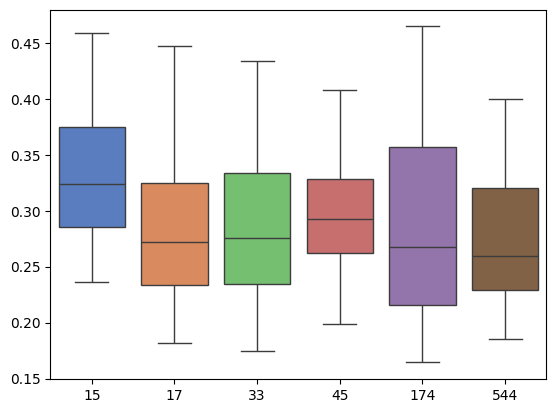

In [19]:
ax = sns.boxplot(pd.DataFrame(missing_stats),
                 palette = sns.color_palette("muted"))


## Missing ratio binning

In [20]:
# general binning
# bin in 5% 

bins = np.arange(0,1,.05)

# dataset binned key order:    dataset: -> metric -> method -> bins ->  list of res "in" bin 
external_metrics_binned = {
    dataset_id:{
        metric:{
            method:{
                bin:[] for bin in bins
                } for method in methods
            } for metric in external_metrics
        } for dataset_id in cfg['dataset_ids']
}

In [21]:
for cfg, v1 in simulation_results.items():

    dataset_id = cfg[0]
    bin = bins[np.digitize(missing_ratios[cfg], bins, right=True)]

    for method, v2 in v1['external_metrics'].items():
        try:
            for metric, v3 in v2.items():
                external_metrics_binned[dataset_id][metric][method][bin].append(v3)
        except:
            for metric in external_metrics:                 
                external_metrics_binned[dataset_id][metric][method][bin].append(np.nan)
            


In [22]:
markers = cycle(['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h'])
linestyles = cycle(['-.',':'])
colors = cycle(sns.color_palette("tab10"))

style = {m:{} for m in methods}
for method in methods:
    style[method]['marker'] = next(markers)
    style[method]['color'] = next(colors)
    if 'mige' in method:
        style[method]['linestyle'] = '-'
    elif 'cca' in method:
        style[method]['linestyle'] = '--'
    else:
        style[method]['linestyle'] = next(linestyles)

C:\Users\simone\AppData\Local\Temp\ipykernel_45244\1390280946.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values)  # Standard error of the mean


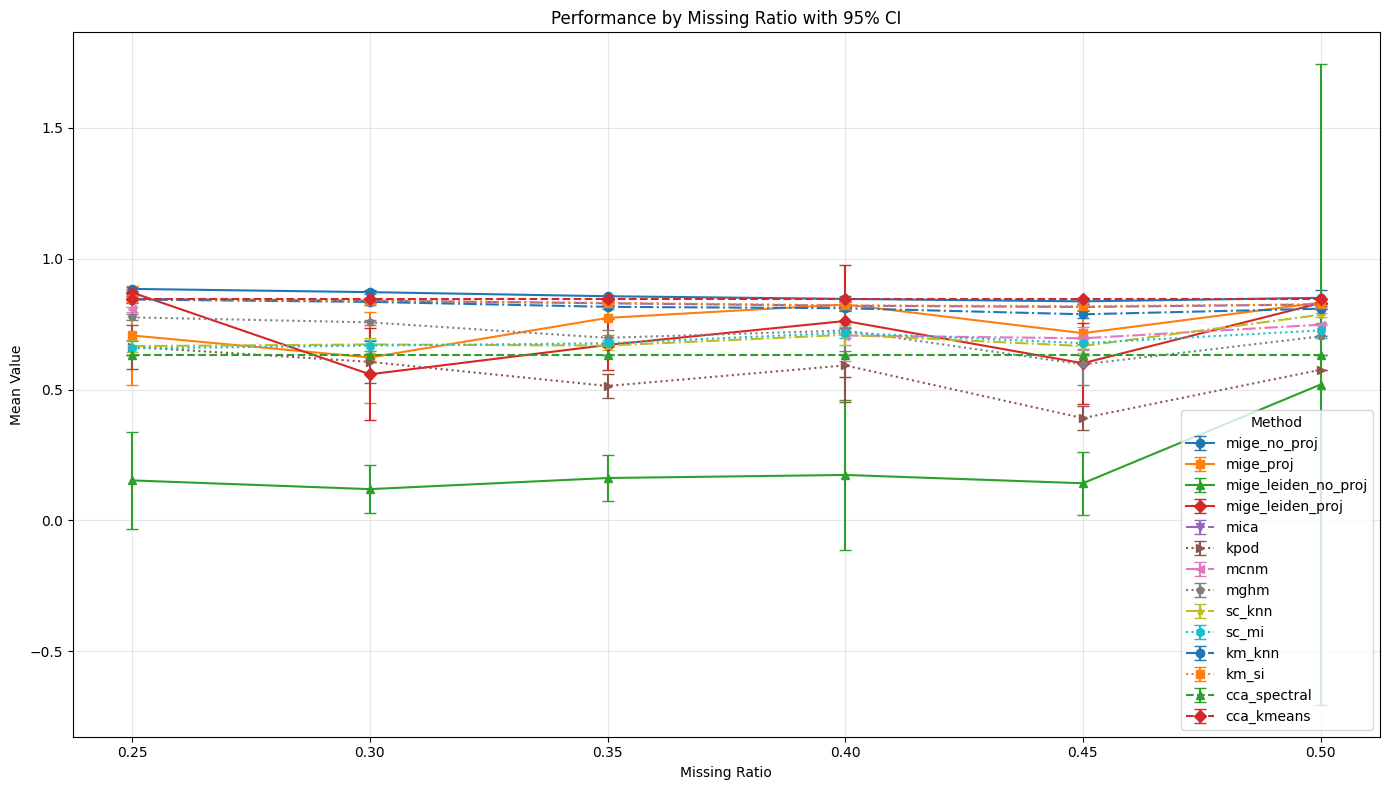

In [24]:
# Example data
data = external_metrics_binned[15]['ari']

plt.figure(figsize=(14, 8))



for method, ratios in data.items():
    x = []
    y = []
    yerr = []
    
    for missing_ratio, values in sorted(ratios.items()):
        mean = np.mean(values)
        sem = stats.sem(values)  # Standard error of the mean
        ci95 = sem * stats.t.ppf(0.975, len(values)-1)  # 95% CI
        
        x.append(missing_ratio)
        y.append(mean)
        yerr.append(ci95)
    
    plt.errorbar(
        x, 
        y, 
        yerr=yerr,
        marker=style[method]['marker'],
        linestyle=style[method]['linestyle'],
        capsize=4, 
        label=method
        )

plt.xlabel("Missing Ratio")
plt.ylabel("Mean Value")
plt.title("Performance by Missing Ratio with 95% CI")
plt.legend(title="Method")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()